<a href="https://colab.research.google.com/github/S-Ngigi/ML/blob/master/Forex_Manenos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import files
!pip install -q kaggle

In [4]:
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [0]:
!mkdir .kaggle && mv kaggle.json .kaggle && mv .kaggle /root/
!chmod 600 /root/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d imetomi/eur-usd-forex-pair-historical-data-2002-2019

 85% 89.0M/105M [00:01<00:00, 52.2MB/s]
100% 105M/105M [00:01<00:00, 60.6MB/s] 


In [7]:
!kaggle datasets download -d maheshtaank/eurusd-daily

  0% 0.00/171k [00:00<?, ?B/s]
100% 171k/171k [00:00<00:00, 52.7MB/s]


In [8]:
import sys
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns

from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.externals import joblib
from sklearn.model_selection import GridSearchCV, train_test_split

import xgboost
from xgboost import XGBRegressor

from zipfile import ZipFile as zp

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [0]:
test_1 =zp('/content/eur-usd-forex-pair-historical-data-2002-2019.zip', 'r')
test_2 =zp('/content/eurusd-daily.zip', 'r')

In [10]:
print(test_1.namelist())
print(test_2.namelist())

['eurusd_hour.csv', 'eurusd_minute.csv', 'eurusd_news.csv']
['eu.csv']


In [11]:
eu_1 = pd.read_csv(test_1.open('eurusd_hour.csv'), index_col=0, parse_dates=True, skipinitialspace=True)
eu_2 = pd.read_csv(test_2.open('eu.csv'), index_col=0, parse_dates=True, skipinitialspace=True)
print(eu_1.shape)
eu_1.head()

(90232, 11)


,Hour,BidOpen,BidHigh,BidLow,BidClose,BidChange,AskOpen,AskHigh,AskLow,AskClose,AskChange
Date,,,,,,,,,,,
2002-05-05,19:00,0.9168,0.9168,0.9168,0.9168,0.0,0.9178,0.9178,0.9178,0.9178,0.0
2002-05-06,20:00,0.9181,0.9181,0.9181,0.9181,0.0,0.9184,0.9184,0.9184,0.9184,0.0
2002-05-07,20:00,0.9152,0.9152,0.9152,0.9152,0.0,0.9155,0.9155,0.9155,0.9155,0.0
2002-05-08,20:00,0.9042,0.9042,0.9042,0.9042,0.0,0.9045,0.9045,0.9045,0.9045,0.0
2002-05-09,20:00,0.9092,0.9092,0.9092,0.9092,0.0,0.9095,0.9095,0.9095,0.9095,0.0


In [12]:
print(eu_2.shape)
eu_2.head()

(12115, 6)


,date,open,high,low,close,volume
1971-01-04,00:00,0.5369,0.5369,0.5369,0.5369,1
1971-01-05,00:00,0.5366,0.5366,0.5366,0.5366,1
1971-01-06,00:00,0.5365,0.5365,0.5365,0.5365,1
1971-01-07,00:00,0.5368,0.5368,0.5368,0.5368,1
1971-01-08,00:00,0.5371,0.5371,0.5371,0.5371,1


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


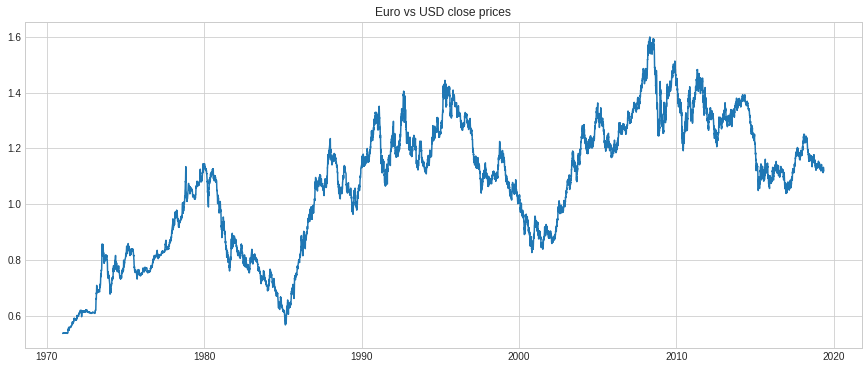

In [13]:
plt.figure(figsize=(15, 6))
plt.plot(eu_2.close)
plt.title('Euro vs USD close prices')
# plt.legend()
plt.show()

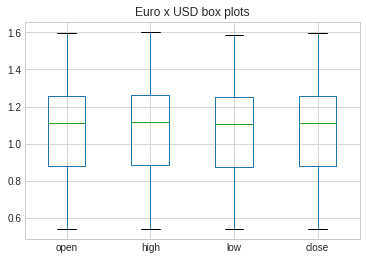

In [14]:
# Plotting box plots for all other features except volume
eu_2.drop('volume', axis=1).boxplot()
plt.title('Euro x USD box plots')
plt.show()

It would seem that the value of most prices were the same.

Below we plot the box whisker distribution of the volume.

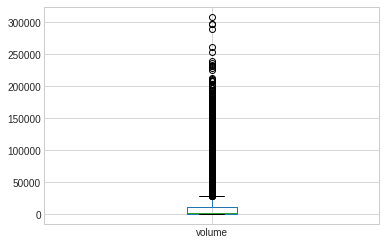

In [15]:
eu_2[['volume']].boxplot()

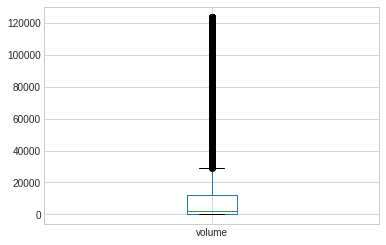

In [18]:
# Creating outlier removal helper function
def outlier_dealer(df_series):
  series = df_series
  # Removing outlier above: Cut off value is the mean + 3 times the std
  high_cut = series.std()*3 + series.mean()
  series[series > high_cut] =high_cut

  # Removing outlier below: Cut off value is the mean - 3 times the std
  low_cut = series.mean() - series.std()*3
  series[series < low_cut] = low_cut
  
  return series

outlier_dealer(eu_2['volume']).plot.box()

Checking effect of removing the outliers

Below we replace volume with series without outliers and check if we get the same results.

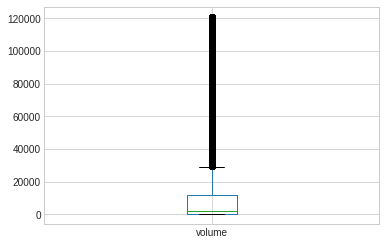

In [19]:
eu_2['volume'] = outlier_dealer(eu_2['volume'])
eu_2[['volume']].boxplot()

In [30]:
def gen_feat(df):
  df_new = pd.DataFrame()

  # Og features
  df_new['open'] = df['open']
  df_new['open_1'] = df['open'].shift(1)
  df_new['close_1'] = df['close'].shift(1)
  df_new['high_1'] = df['high'].shift(1)
  df_new['low_1'] = df['low'].shift(1)
  df_new['volume_1'] = df['volume'].shift(1)

  # average price features
  df_new['avg_price_wk'] = df['close'].rolling(window=5).mean().shift(1)
  df_new['avg_price_mnth'] = df['close'].rolling(window=21).mean().shift(1)
  df_new['avg_price_3mnth'] = df['close'].rolling(window=63).mean().shift(1)
  df_new['avg_price_yr'] = df['close'].rolling(window=252).mean().shift(1)

  # average price ratio
  df_new['wk_mnth_ratio_pra'] = df_new['avg_price_wk']/df_new['avg_price_mnth']
  df_new['wk_3mnth_ratio_pra'] = df_new['avg_price_wk']/df_new['avg_price_3mnth']
  df_new['wk_yr_ratio_pra'] = df_new['avg_price_wk']/df_new['avg_price_yr']
  df_new['mnth_3mnth_ratio_pra'] = df_new['avg_price_mnth']/df_new['avg_price_3mnth']
  df_new['mnth_yr_ratio_pra'] = df_new['avg_price_mnth']/df_new['avg_price_yr']
  df_new['3mnth_yr_ratio_pra'] = df_new['avg_price_3mnth']/df_new['avg_price_yr']

   # standard dev price features
  df_new['std_price_wk'] = df['close'].rolling(window=5).std().shift(1)
  df_new['std_price_mnth'] = df['close'].rolling(window=21).std().shift(1)
  df_new['std_price_3mnth'] = df['close'].rolling(window=63).std().shift(1)
  df_new['std_price_yr'] = df['close'].rolling(window=252).std().shift(1)

  # standard dev price ratio
  df_new['wk_mnth_ratio_prs'] = df_new['std_price_wk']/df_new['std_price_mnth']
  df_new['wk_3mnth_ratio_prs'] = df_new['std_price_wk']/df_new['std_price_3mnth']
  df_new['wk_yr_ratio_prs'] = df_new['std_price_wk']/df_new['std_price_3mnth']
  df_new['mnth_3mnth_ratio_prs'] = df_new['std_price_mnth']/df_new['std_price_yr']
  df_new['mnth_yr_ratio_prs'] = df_new['std_price_mnth']/df_new['std_price_yr']
  df_new['3mnth_yr_ratio_prs'] = df_new['std_price_3mnth']/df_new['std_price_yr']

  # average volume
  df_new['avg_vol_wk'] = df['volume'].rolling(window=5).mean().shift(1)
  df_new['avg_vol_mnth'] = df['volume'].rolling(window=21).mean().shift(1)
  df_new['avg_vol_3mnth'] = df['volume'].rolling(window=63).mean().shift(1)
  df_new['avg_vol_yr'] = df['volume'].rolling(window=252).mean().shift(1)

  # Average volume ratios
  df_new['wk_mnth_ratio_vola'] = df_new['avg_vol_wk']/df_new['avg_vol_mnth']
  df_new['wk_3mnth_ratio_vola'] = df_new['avg_vol_wk']/df_new['avg_vol_3mnth']
  df_new['wk_yr_ratio_vola'] = df_new['avg_vol_wk']/df_new['avg_vol_yr']
  df_new['mnth_3mnth_ratio_vola'] = df_new['avg_vol_mnth']/df_new['avg_vol_3mnth']
  df_new['mnth_yr_ratio_vola'] = df_new['avg_vol_mnth']/df_new['avg_vol_yr']
  df_new['3mnth_yr_ratio_vola'] = df_new['avg_vol_3mnth']/df_new['avg_vol_yr']

  # standard dev volume
  df_new['std_vol_wk'] = df['volume'].rolling(window=5).std().shift(1)
  df_new['std_vol_mnth'] = df['volume'].rolling(window=21).std().shift(1)
  df_new['std_vol_3mnth'] = df['volume'].rolling(window=63).std().shift(1)
  df_new['std_vol_yr'] = df['volume'].rolling(window=252).std().shift(1)

  # standard dev volume ratios
  df_new['wk_mnth_ratio_vola'] = df_new['std_vol_wk']/df_new['std_vol_mnth']
  df_new['wk_3mnth_ratio_vola'] = df_new['std_vol_wk']/df_new['std_vol_3mnth']
  df_new['wk_yr_ratio_vola'] = df_new['std_vol_wk']/df_new['std_vol_yr']
  df_new['mnth_3mnth_ratio_vola'] = df_new['std_vol_mnth']/df_new['std_vol_3mnth']
  df_new['mnth_yr_ratio_vola'] = df_new['std_vol_mnth']/df_new['std_vol_yr']
  df_new['3mnth_yr_ratio_vola'] = df_new['std_vol_3mnth']/df_new['std_vol_yr']

  # return
  df_new['ret_1'] = ((df['close'] - df['close'].shift(1)) / df['close'].shift(1)).shift(1)
  df_new['ret_wk'] = ((df['close'] - df['close'].shift(5)) / df['close'].shift(5)).shift(1)
  df_new['ret_mnth'] = ((df['close'] - df['close'].shift(21)) / df['close'].shift(21)).shift(1)
  df_new['ret_3mnth'] = ((df['close'] - df['close'].shift(63)) / df['close'].shift(63)).shift(1)                                                
  df_new['ret_yr'] = ((df['close'] - df['close'].shift(252)) / df['close'].shift(252)).shift(1)

  #average of return
  df_new['moving_avg_5'] = df_new['ret_1'].rolling(window=5).mean()
  df_new['moving_avg_30'] = df_new['ret_1'].rolling(window=21).mean()
  df_new['moving_avg_30'] = df_new['ret_1'].rolling(window=63).mean()
  df_new['moving_avg_365'] = df_new['ret_1'].rolling(window=252).mean()

  # The target
  df_new['close'] = df['close']
  return df_new


data = gen_feat(eu_2)
data.head()

,open,open_1,close_1,high_1,low_1,volume_1,avg_price_wk,avg_price_mnth,avg_price_3mnth,avg_price_yr,wk_mnth_ratio_pra,wk_3mnth_ratio_pra,wk_yr_ratio_pra,mnth_3mnth_ratio_pra,mnth_yr_ratio_pra,3mnth_yr_ratio_pra,std_price_wk,std_price_mnth,std_price_3mnth,std_price_yr,wk_mnth_ratio_prs,wk_3mnth_ratio_prs,wk_yr_ratio_prs,mnth_3mnth_ratio_prs,mnth_yr_ratio_prs,3mnth_yr_ratio_prs,avg_vol_wk,avg_vol_mnth,avg_vol_3mnth,avg_vol_yr,wk_mnth_ratio_vola,wk_3mnth_ratio_vola,wk_yr_ratio_vola,mnth_3mnth_ratio_vola,mnth_yr_ratio_vola,3mnth_yr_ratio_vola,std_vol_wk,std_vol_mnth,std_vol_3mnth,std_vol_yr,ret_1,ret_wk,ret_mnth,ret_3mnth,ret_yr,moving_avg_5,moving_avg_30,moving_avg_365,close
1971-01-04,0.5369,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5369
1971-01-05,0.5366,0.5369,0.5369,0.5369,0.5369,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5366
1971-01-06,0.5365,0.5366,0.5366,0.5366,0.5366,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.000559,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5365
1971-01-07,0.5368,0.5365,0.5365,0.5365,0.5365,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.000186,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5368
1971-01-08,0.5371,0.5368,0.5368,0.5368,0.5368,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000559,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5371


In [31]:
print(data.shape)
data.isna().sum()

(12115, 49)

In [28]:
df_new

,open,open_1,close_1,high_1,low_1,volume_1
1971-01-04,0.53690,NaN,NaN,NaN,NaN,NaN
1971-01-05,0.53660,0.53690,0.53690,0.53690,0.53690,1.0
1971-01-06,0.53650,0.53660,0.53660,0.53660,0.53660,1.0
1971-01-07,0.53680,0.53650,0.53650,0.53650,0.53650,1.0
1971-01-08,0.53710,0.53680,0.53680,0.53680,0.53680,1.0
...,...,...,...,...,...,...
2019-05-01,1.12148,1.11841,1.12140,1.12286,1.11753,55570.0
2019-05-02,1.11942,1.12148,1.11941,1.12644,1.11867,52561.0
2019-05-03,1.11710,1.11942,1.11709,1.12187,1.11703,59203.0
2019-05-08,1.11922,1.11710,1.13234,1.13236,1.11346,62828.0


In [0]:
def gen_feat(df):
  df_new = pd.DataFrame()

  # Og features
  df_new['open'] = df['open']
  df_new['open_1'] = df['open'].shift(1)
  df_new['close_1'] = df['close'].shift(1)
  df_new['high_1'] = df['high'].shift(1)
  df_new['low_1'] = df['low'].shift(1)
  df_new['volume_1'] = df['volume'].shift(1)

  # average price features
  df_new['avg_price_wk'] = df['close'].rolling(window=5).mean().shift(1)
  df_new['avg_price_mnth'] = df['close'].rolling(window=21).mean().shift(1)
  df_new['avg_price_3mnth'] = df['close'].rolling(window=63).mean().shift(1)
  df_new['avg_price_yr'] = df['close'].rolling(window=252).mean().shift(1)

  # average price ratio
  df_new['wk_mnth_ratio_pra'] = df_new['avg_price_wk']/df_new['avg_price_mnth']
  df_new['wk_3mnth_ratio_pra'] = df_new['avg_price_wk']/df_new['avg_price_3mnth']
  df_new['wk_yr_ratio_pra'] = df_new['avg_price_wk']/df_new['avg_price_yr']
  df_new['mnth_3mnth_ratio_pra'] = df_new['avg_price_mnth']/df_new['avg_price_3mnth']
  df_new['mnth_yr_ratio_pra'] = df_new['avg_price_mnth']/df_new['avg_price_yr']
  df_new['3mnth_yr_ratio_pra'] = df_new['avg_price_3mnth']/df_new['avg_price_yr']

   # standard dev price features
  df_new['std_price_wk'] = df['close'].rolling(window=5).std().shift(1)
  df_new['std_price_mnth'] = df['close'].rolling(window=21).std().shift(1)
  df_new['std_price_3mnth'] = df['close'].rolling(window=63).std().shift(1)
  df_new['std_price_yr'] = df['close'].rolling(window=252).std().shift(1)

  # standard dev price ratio
  df_new['wk_mnth_ratio_prs'] = df_new['std_price_wk']/df_new['std_price_mnth']
  df_new['wk_3mnth_ratio_prs'] = df_new['std_price_wk']/df_new['std_price_3mnth']
  df_new['wk_yr_ratio_prs'] = df_new['std_price_wk']/df_new['std_price_3mnth']
  df_new['mnth_3mnth_ratio_prs'] = df_new['std_price_mnth']/df_new['std_price_yr']
  df_new['mnth_yr_ratio_prs'] = df_new['std_price_mnth']/df_new['std_price_yr']
  df_new['3mnth_yr_ratio_prs'] = df_new['std_price_3mnth']/df_new['std_price_yr']

  # average volume
  df_new['avg_vol_wk'] = df['volume'].rolling(window=5).mean().shift(1)
  df_new['avg_vol_mnth'] = df['volume'].rolling(window=21).mean().shift(1)
  df_new['avg_vol_3mnth'] = df['volume'].rolling(window=63).mean().shift(1)
  df_new['avg_vol_yr'] = df['volume'].rolling(window=252).mean().shift(1)

  # Average volume ratios
  df_new['wk_mnth_ratio_vola'] = df_new['avg_vol_wk']/df_new['avg_vol_mnth']
  df_new['wk_3mnth_ratio_vola'] = df_new['avg_vol_wk']/df_new['avg_vol_3mnth']
  df_new['wk_yr_ratio_vola'] = df_new['avg_vol_wk']/df_new['avg_vol_yr']
  df_new['mnth_3mnth_ratio_vola'] = df_new['avg_vol_mnth']/df_new['avg_vol_3mnth']
  df_new['mnth_yr_ratio_vola'] = df_new['avg_vol_mnth']/df_new['avg_vol_yr']
  df_new['3mnth_yr_ratio_vola'] = df_new['avg_vol_3mnth']/df_new['avg_vol_yr']

  # standard dev volume
  df_new['std_vol_wk'] = df['volume'].rolling(window=5).std().shift(1)
  df_new['std_vol_mnth'] = df['volume'].rolling(window=21).std().shift(1)
  df_new['std_vol_3mnth'] = df['volume'].rolling(window=63).std().shift(1)
  df_new['std_vol_yr'] = df['volume'].rolling(window=252).std().shift(1)

  # standard dev volume ratios
  df_new['wk_mnth_ratio_vola'] = df_new['std_vol_wk']/df_new['std_vol_mnth']
  df_new['wk_3mnth_ratio_vola'] = df_new['std_vol_wk']/df_new['std_vol_3mnth']
  df_new['wk_yr_ratio_vola'] = df_new['std_vol_wk']/df_new['std_vol_yr']
  df_new['mnth_3mnth_ratio_vola'] = df_new['std_vol_mnth']/df_new['std_vol_3mnth']
  df_new['mnth_yr_ratio_vola'] = df_new['std_vol_mnth']/df_new['std_vol_yr']
  df_new['3mnth_yr_ratio_vola'] = df_new['std_vol_3mnth']/df_new['std_vol_yr']

  # return
  df_new['ret_1'] = ((df['close'] - df['close'].shift(1)) / df['close'].shift(1)).shift(1)
  df_new['ret_wk'] = ((df['close'] - df['close'].shift(5)) / df['close'].shift(5)).shift(1)
  df_new['ret_mnth'] = ((df['close'] - df['close'].shift(21)) / df['close'].shift(21)).shift(1)
  df_new['ret_3mnth'] = ((df['close'] - df['close'].shift(63)) / df['close'].shift(63)).shift(1)                                                
  df_new['ret_yr'] = ((df['close'] - df['close'].shift(252)) / df['close'].shift(252)).shift(1)

  #average of return
  df_new['moving_avg_5'] = df_new['ret_1'].rolling(window=5).mean()
  df_new['moving_avg_30'] = df_new['ret_1'].rolling(window=21).mean()
  df_new['moving_avg_30'] = df_new['ret_1'].rolling(window=63).mean()
  df_new['moving_avg_365'] = df_new['ret_1'].rolling(window=252).mean()

  # The target
  df_new['close'] = df['close']
  df_new = df_new.dropna(axis=0)
  return df_new


data = gen_feat(eu_2)
data.head()